# Ekstraksi Kata Kunci dengan Text Rank

Rumus TextRank:

$$ W_i = (1 - d) + d \cdot \sum_{j \in In(i)} \frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}} \cdot W_j $$

Penjelasan unsur-unsur dalam rumus tersebut:

- $(W_i)$: Skor TextRank untuk kata $(i)$.
- $(d)$: Faktor redaman (damping factor), seringkali bernilai sekitar 0.85.
- $(In(i))$: Himpunan kata-kata yang memiliki hubungan (edge) masuk ke kata $(i)$.
- $(Out(j))$: Himpunan kata-kata yang memiliki hubungan keluar dari kata $(j)$.
- $(w_{ij})$: Bobot hubungan antara kata $(i)$ dan $(j)$.


Penjelasan langkah-langkah rumus:

1. $(1 - d)$: Bagian dari rumus yang menyatakan kontribusi dampak faktor redaman.
2. $(\sum_{j \in In(i)})$: Penjumlahan atas kata-kata yang memiliki hubungan masuk ke kata $(i)$.
3. $(\frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}})$: Bagian yang menghitung kontribusi dari setiap kata yang memiliki hubungan keluar dari kata $(j)$. Fungsi ini memperhitungkan bobot relatif dari setiap hubungan keluar dari kata $(j)$.
4. $(W_j)$: Skor TextRank dari kata $(j)$. Skor ini dihitung pada iterasi sebelumnya dan digunakan untuk menghitung skor baru untuk kata $(i)$.

Dengan mengulangi rumus ini melalui beberapa iterasi, nilai skor TextRank untuk setiap kata akan konvergen ke nilai yang mencerminkan tingkat kepentingan kata-kata dalam teks. Pada akhirnya, kata-kata dengan skor TextRank tertinggi dianggap sebagai kata kunci atau kata-kata yang paling penting dalam teks tersebut.

## Perhitungan Manual (Spreadsheet)

[Text Rank Perhitungan Manual SpreadSheet](https://docs.google.com/spreadsheets/d/1TeWV35ZgZQ11l2bl7BeWxoMFWZHUlpQXM3E1miQzdhU/edit?usp=sharing)

In [46]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
corpus = stopwords.words('indonesian')
def stopwords(text):
  return ' '.join(word for word in text.split() if word not in corpus)

In [48]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=figsize)

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

In [49]:
def graph_co_occurrence(x, show_matrics=False):
  vectorizer = CountVectorizer()
  tfidf_matrics = vectorizer.fit_transform(x)
  co_occurrence_matrix = tfidf_matrics.T.dot(tfidf_matrics).toarray()
  df_co_occurence = pd.DataFrame(co_occurrence_matrix, columns=vectorizer.get_feature_names_out())
  df_co_occurence.insert(0, 'Word', vectorizer.get_feature_names_out())

  if show_matrics:
    print("Tabel Co-occurence Matrics: ")
    display(df_co_occurence)
    print()

  # Membuat graf berbobot menggunakan NetworkX
  G = nx.DiGraph()
  num_words = co_occurrence_matrix.shape[0]

  # Menambahkan edge ke graf berdasarkan matriks co-occurrence
  for i in range(num_words):
    for j in range(i + 1, num_words):
      weight = co_occurrence_matrix[i, j]
      if weight > 0:
        G.add_edge(vectorizer.get_feature_names_out()[i], vectorizer.get_feature_names_out()[j], weight=weight)
  return G

In [50]:
def text_rank(graph, damping_factor=0.85, max_iter=100, tol=1e-4):
  # Inisialisasi nilai TextRank untuk setiap node
  initial_value = 1 / graph.number_of_nodes()
  ranks = {node: initial_value for node in graph.nodes()}

  print(f"Inisialisasi Score Awal : {ranks}")
  print(f"Edges : {graph.edges()}")
  print()

  for i in range(max_iter):
    new_ranks = {}
    print(f"========== Iterasi Ke - {i} ==========")

    for node in graph.nodes():
      rank_sum = 0
      operasi = ''

      # Menampilkan informasi out_sum dan win untuk setiap node dan neighbor
      out_sums_info = {}
      win = graph.in_degree(node, weight="weight")

      for neighbor in graph.predecessors(node):
        edge_weight = graph[neighbor][node]["weight"]
        out_sum = sum(graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor))
        rank_sum += (edge_weight / out_sum) * ranks[neighbor]
        operasi += f"({edge_weight}/{out_sum}) * {ranks[neighbor]} + "

        # Menambah informasi out_sum untuk setiap neighbor
        out_sums_info[neighbor] = {out_neighbor: graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor)}

      # Jika operasi kosong, atur nilai operasi menjadi 0
      operasi = operasi[:-3] if operasi else '0'

      new_rank = (1 - damping_factor) + damping_factor * rank_sum
      new_ranks[node] = new_rank

      # Menampilkan informasi out_sum dan win pada setiap iterasi
      print(f"Win({node}): {win}")
      print(f"Out_sums_info({node}): {out_sums_info}")
      print(f"W({node}) = (1 - {damping_factor}) + {damping_factor} * ({operasi}) = {new_rank}")
      print()

    # Periksa konvergensi
    convergence = all(abs(new_ranks[node] - ranks[node]) < tol for node in graph.nodes())
    ranks = new_ranks
    print(f"New Score : {new_ranks}")
    print()

    if convergence:
      print(f"Konvergensi tercapai pada iterasi ke-{i}")
      break

  return ranks

In [51]:
def extract_top_words(x, w=3, show_matrics=False, show_scores=False, index=None):
    full_text = ' '.join(word for word in x)

    # Stopwords removal
    x = [stopwords(full_text)]

    G = graph_co_occurrence(x, show_matrics)

    # Menghitung nilai dari PageRank (TextRank)
    scores = text_rank(G)

    # Dictionary untuk menyimpan skor tertinggi setiap kata
    ranked_words_dict = {}

    for word in ' '.join(x).split():
        current_score = scores.get(word, 0)
        if word not in ranked_words_dict or current_score > ranked_words_dict[word]:
            ranked_words_dict[word] = current_score

    # Mengurutkan kata-kata berdasarkan skor tertinggi
    ranked_words = sorted(((score, word) for word, score in ranked_words_dict.items()), key=lambda x: (x[0], x[1]), reverse=True)

    # Memilih sejumlah w kata tertinggi
    selected_words = [word for _, word in ranked_words[:w]] if w is not None else None

    # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
    keywords = ', '.join(selected_words) if selected_words else ''

    if show_scores:
      print(f'Dokumen ke {index} : {full_text}')
      print(f'{w} Kata Kunci : {keywords}')
      print("TextRank Scores:")
      for score, word in ranked_words:
          print(f"Skor: {score}, Kata: {word}")

    return (G, selected_words)

In [52]:
text1 = ['pemandangan gunung semeru indah']
G1, keywords1 = extract_top_words(text1, w=2, show_matrics=True)

Tabel Co-occurence Matrics: 


,Word,gunung,indah,pemandangan,semeru
0,gunung,1,1,1,1
1,indah,1,1,1,1
2,pemandangan,1,1,1,1
3,semeru,1,1,1,1



Inisialisasi Score Awal : {'gunung': 0.25, 'indah': 0.25, 'pemandangan': 0.25, 'semeru': 0.25}
Edges : [('gunung', 'indah'), ('gunung', 'pemandangan'), ('gunung', 'semeru'), ('indah', 'pemandangan'), ('indah', 'semeru'), ('pemandangan', 'semeru')]

========== Iterasi Ke - 0 ==========
Win(gunung): 0
Out_sums_info(gunung): {}
W(gunung) = (1 - 0.85) + 0.85 * (0) = 0.15000000000000002

Win(indah): 1
Out_sums_info(indah): {'gunung': {'indah': 1, 'pemandangan': 1, 'semeru': 1}}
W(indah) = (1 - 0.85) + 0.85 * ((1/3) * 0.25) = 0.22083333333333335

Win(pemandangan): 2
Out_sums_info(pemandangan): {'gunung': {'indah': 1, 'pemandangan': 1, 'semeru': 1}, 'indah': {'pemandangan': 1, 'semeru': 1}}
W(pemandangan) = (1 - 0.85) + 0.85 * ((1/3) * 0.25 + (1/2) * 0.25) = 0.32708333333333334

Win(semeru): 3
Out_sums_info(semeru): {'gunung': {'indah': 1, 'pemandangan': 1, 'semeru': 1}, 'indah': {'pemandangan': 1, 'semeru': 1}, 'pemandangan': {'semeru': 1}}
W(semeru) = (1 - 0.85) + 0.85 * ((1/3) * 0.25 + (1

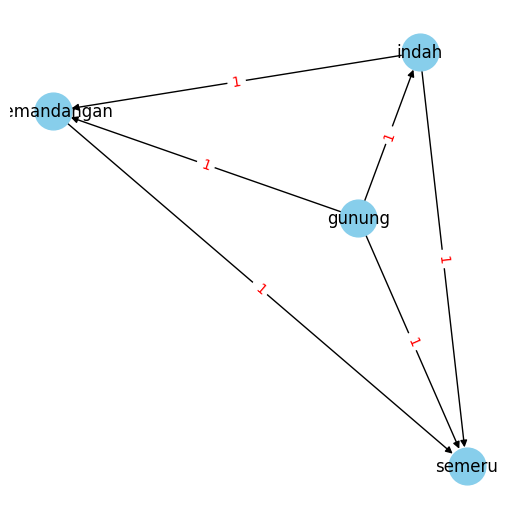

In [53]:
plot_graph(G1, figsize=(5, 5), node_size=700,)

In [54]:
keywords1

['semeru', 'pemandangan']

## Text Rank

In [55]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
df = pd.read_csv('https://raw.githubusercontent.com/pramdf042/PPW/main/crawling_viva_fix.csv')
df

,Judul,Isi Berita,Link,Kategori
0,Terpopuler: Tentara Israel Frustasi Dihujat Wa...,Round Up – Perang Israel-Hamas di Jalur Gaza t...,https://www.viva.co.id/berita/nasional/1660151...,nasional
1,"Jadi Tersangka Pemerasan, Firli Bahuri Teranca...",Jakarta - Ketua Komisi Pemberantasan Korupsi (...,https://www.viva.co.id/berita/nasional/1660272...,nasional
2,"Firli Bahuri Ditetapkan Tersangka, Eks Pegawai...",Jakarta – Ketua wadah pegawai KPK Yudi Purnomo...,https://www.viva.co.id/berita/nasional/1660271...,nasional
3,Kondisi Terkini 4 Korban Luka Kecelakaan Minib...,Surabaya – Empat korban luka berat dalam insid...,https://www.viva.co.id/berita/nasional/1660237...,nasional
4,Polisi Segera Periksa Firli sebagai Tersangka ...,Jakarta- Polisi segera mengagendakan pemeriksa...,https://www.viva.co.id/berita/nasional/1660268...,nasional
...,...,...,...,...
67,Firli Bahuri Resmi Jadi Tersangka Kasus Pemera...,Jakarta – Polda Metro Jaya menetapkan Ketua Ko...,https://www.viva.co.id/berita/nasional/1660262...,kriminal
68,"Jadi Tersangka Pemerasan, Firli Bahuri Teranca...",Jakarta - Ketua Komisi Pemberantasan Korupsi (...,https://www.viva.co.id/berita/nasional/1660272...,kriminal
69,Kronologi Lengkap Kasus Mutilasi Mahasiswa UMY,Yogyakarta – Dua terdakwa kasus mutilasi terha...,https://www.viva.co.id/berita/kriminal/1660261...,kriminal
70,"Firli Bahuri Ditetapkan Tersangka, Eks Pegawai...",Jakarta – Ketua wadah pegawai KPK Yudi Purnomo...,https://www.viva.co.id/berita/nasional/1660271...,kriminal


In [57]:
df.isnull().sum()

Judul         0
Isi Berita    0
Link          0
Kategori      0
dtype: int64

In [59]:
def cleaning(text):
  text = re.sub(r'[^\w\s.?!,]', '', text).strip().lower()
  return text

df['Cleaning'] = df['Isi Berita'].apply(cleaning)
df['Cleaning']

0     round up  perang israelhamas di jalur gaza ter...
1     jakarta  ketua komisi pemberantasan korupsi kp...
2     jakarta  ketua wadah pegawai kpk yudi purnomo ...
3     surabaya  empat korban luka berat dalam inside...
4     jakarta polisi segera mengagendakan pemeriksaa...
                            ...                        
67    jakarta  polda metro jaya menetapkan ketua kom...
68    jakarta  ketua komisi pemberantasan korupsi kp...
69    yogyakarta  dua terdakwa kasus mutilasi terhad...
70    jakarta  ketua wadah pegawai kpk yudi purnomo ...
71    pasuruan  seorang caleg muda pkb kabupaten pas...
Name: Cleaning, Length: 72, dtype: object

In [60]:
corpus = stopwords.words('indonesian')

def stopwordText(text):
  return ' '.join(word for word in text.split() if word not in corpus)

df['Stopword Removal'] = df['Cleaning'].apply(stopwordText)

In [61]:
def tokenizer(text):
  text = text.lower()
  return sent_tokenize(text)

df['Tokenizing'] = df['Stopword Removal'].apply(tokenizer)
df['Tokenizing']

0     [round up perang israelhamas jalur gaza menyit...
1     [jakarta ketua komisi pemberantasan korupsi kp...
2     [jakarta ketua wadah pegawai kpk yudi purnomo ...
3     [surabaya korban luka berat insiden minibus di...
4     [jakarta polisi mengagendakan pemeriksaan ketu...
                            ...                        
67    [jakarta polda metro jaya menetapkan ketua kom...
68    [jakarta ketua komisi pemberantasan korupsi kp...
69    [yogyakarta terdakwa mutilasi mahasiswa univer...
70    [jakarta ketua wadah pegawai kpk yudi purnomo ...
71    [pasuruan caleg muda pkb kabupaten pasuruan be...
Name: Tokenizing, Length: 72, dtype: object

In [62]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=(35, 30))

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

In [63]:
def graph_co_occurrence(x, threshold=0, show_matrics = False):
    vectorizer = CountVectorizer()
    tfidf_matrics = vectorizer.fit_transform(x)
    co_occurrence_matrix = tfidf_matrics.T.dot(tfidf_matrics).toarray()
    df_co_occurence = pd.DataFrame(co_occurrence_matrix, columns=vectorizer.get_feature_names_out())

    if show_matrics:
      display(df_co_occurence)

    G = nx.DiGraph()

    # Menambahkan edge ke graf berdasarkan matriks co-occurrence
    for i in range(len(co_occurrence_matrix)):
      for j in range(i + 1, len(co_occurrence_matrix)):
        weight = co_occurrence_matrix[i, j]
        if weight > threshold:
          G.add_edge(vectorizer.get_feature_names_out()[i], vectorizer.get_feature_names_out()[j], weight=weight)
    return G

In [64]:
def extract_top_words(x, w=3, threshold=0, show_matrics=False, show_scores=False, index=None):
    full_text = ' '.join(word for word in x)

    G = graph_co_occurrence(x, threshold, show_matrics)

    # Menghitung nilai dari PageRank (TextRank)
    scores = nx.pagerank(G)

    # Dictionary untuk menyimpan skor tertinggi setiap kata
    ranked_words_dict = {}

    for word in ' '.join(x).split():
        current_score = scores.get(word, 0)
        if word not in ranked_words_dict or current_score > ranked_words_dict[word]:
            ranked_words_dict[word] = current_score

    # Mengurutkan kata-kata berdasarkan skor tertinggi
    ranked_words = sorted(((score, word) for word, score in ranked_words_dict.items()), key=lambda x: (x[0], x[1]), reverse=True)

    # Memilih sejumlah w kata tertinggi
    selected_words = [word for _, word in sorted(ranked_words[:w], key=lambda x: x[1])] if w is not None else None

    # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
    keywords = ', '.join(selected_words) if selected_words else ''

    if show_scores:
      print(f'Dokumen ke {index} : {full_text}')
      print(f'{w} Kata Kunci : {keywords}')
      print("TextRank Scores:")
      for score, word in ranked_words:
          print(f"Skor: {score}, Kata: {word}")

    return (G, selected_words)

In [65]:
def extract_all(x, w=4, plot=False, show_matrics=False, show_scores=False, index=1, threshold=0):

  # G = graph_co_occurrence(x, show_matrics)

  G, top_words = extract_top_words(x, w, threshold, show_matrics, show_scores, index)

  if plot:
    print()
    print("Plot Graph :")
    plot_graph(G)

  # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
  keywords = ', '.join(top_words) if top_words else ''

  return keywords

In [68]:
example = df["Tokenizing"].iloc[1]
example

['jakarta ketua komisi pemberantasan korupsi kpk, firli bahuri terancam pidana penjara seumur hidup buntut ditetapkan tersangka dugaan pemerasan penerimaan gratifikasi penanganan korupsi kementerian pertanian kementan 2021. firli dikenakan pasal 12e pasal 12b pasal 11 uu 311999 diubah uu 202001 perubahan uu 311999 pemberantasan tindak pidana korupsi juncto pasal 65 kuhp.',
 'rentetan pasal berlapis itu, firli terancam hukuman berat penjara seumur hidup pasal 12b ayat 1 terkait penerimaan gratifikasi pegawai negeri penyelenggara negara.',
 'diungkap direktur reserse kriminal khusus polda metro jaya, komisaris polisi ade safri simanjuntak.',
 'ayat 1, dipidana seumur hidup pidana penjara singkat 20 tahun.',
 'pidana denda rp200 juta rp1 miliar, wartawan, kamis 23 november 2023. ade penetapan firli tersangka penyidik menemukan bukti cukup.',
 'mantan kapolres kota solo mengatakan, 91 orang diperiksa saksi dugaan pemerasan eks menteri pertanian syahrul yasin limpo syl itu.',
 'menetapkan s

In [69]:
keyword =  extract_all(example, w=3, show_matrics=True, plot=True, show_scores=True, index=1)

Output hidden; open in https://colab.research.google.com to view.